# 1. Data Gathering and Analysis

The aim of our project is to understand the general themes and level of engagement surrounding the anime series Attack on Titan (AOT). In particular, we are interested in analysing how the community's sentiment changes over time, given that a TV series releases episodes over a very long period. There are two critical points: the ending of the manga and the ending of the anime series. The ending of AoT is still a topic of debate within the community, with very polarised opinions – you either accept it or you hate it; there are no half measures.

`SPOILER ALERT`: Unfortunately, this contains spoilers if you intend to watch the show but haven't already done so.

Table of contents:
- Data Gathering
- Basic Data Analysis

In [5]:
import praw
import pandas as pd
import json
from datetime import datetime
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Data Gathering

In [6]:
# login with your reddit credentials

def login_reddit(reddit_credentials):
    with open(reddit_credentials, "r") as f:
        credentials = json.load(f)

    reddit = praw.Reddit(
        client_id=credentials['CLIENT_ID'],
        client_secret=credentials['SECRET_TOKEN'],
        password=credentials['PASSWORD'],
        user_agent='https://github.com/AlessandroGhiotto/WSA-AoT',
        username=credentials['USERNAME'],
        check_for_async=False
    )

    if reddit.read_only:
        print("Reddit login failed. Please check your credentials.")
        return None
    else:
        print(f"🤖 Reddit login successful. Welcome {reddit.user.me()}")
        return reddit
    
reddit_credentials = "../data/redditCredentials.json"
reddit = login_reddit(reddit_credentials)

🤖 Reddit login successful. Welcome Disastrous_Walk_7254


In [7]:
def get_reddit_submissions(subreddit_name, query=None, limit=100, what_items=None):
    """
    Get submissions from a subreddit based on a query.
    - subreddit_name: Name of the subreddit to search in.
    - query: Search query string (for keywords with AND, OR,...).
    - limit: Maximum number of submissions to retrieve.
    - what_items: string
            - None: use .search() method
            - 'hot': use .hot() method
            - 'new': use .new() method
            - 'top': use .top() method
    - return: DataFrame containing submission data.
    """

    # this is going to contain a list of dictionaries, each dictionary will contain the data of a submission
    submissions_data = []

    # get submissions
    if what_items is not None:
        if what_items == 'hot':
            submissions = reddit.subreddit(subreddit_name).hot(limit=limit)
        elif what_items == 'new':
            submissions = reddit.subreddit(subreddit_name).new(limit=limit)
        elif what_items == 'top':
            submissions = reddit.subreddit(subreddit_name).top(limit=limit)
        else:
            raise ValueError("Invalid value for 'what_items'. Use None, 'hot', 'new', or 'top'.")
    else:
        if query is None:
            raise ValueError("Query must be provided when 'what_items' is None.")
        submissions = reddit.subreddit(subreddit_name).search(query, limit=limit)

    # iterate
    for submission in submissions:
        submission_data = {
            'author': '',
            'author_flair_text': '',
            'clicked': submission.clicked,
            'comments': submission.comments,
            'created_utc': submission.created_utc,
            'distinguished': submission.distinguished,
            'edited': submission.edited,
            'id': submission.id,
            'is_original_content': submission.is_original_content,
            'is_self': submission.is_self,
            'link_flair_template_id': '',
            'link_flair_text': '',
            'locked': submission.locked,
            'name': submission.name,
            'num_comments': submission.num_comments,
            'over_18': submission.over_18,
            'permalink': submission.permalink,
            'poll_data': '',
            'saved': submission.saved,
            'score': submission.score,
            'selftext': '',
            'spoiler': submission.spoiler,
            'stickied': submission.stickied,
            'subreddit': submission.subreddit,
            'title': submission.title,
            'upvote_ratio': submission.upvote_ratio,
            'url': submission.url
        }

        try:
            submission_data['poll_data'] = submission.poll_data
        except AttributeError:
            pass

        try:
            submission_data['author'] = submission.author
        except AttributeError:
            pass

        try:
            submission_data['author_flair_text'] = submission.author_flair_text
        except AttributeError:
            pass

        try:
            submission_data['link_flair_text'] = submission.link_flair_text
        except AttributeError:
            pass

        try:
            submission_data['link_flair_template_id'] = submission.link_flair_template_id
        except AttributeError:
            pass

        try:
            submission_data['selftext'] = submission.selftext
        except AttributeError:
            pass

        # append to results
        submissions_data.append(submission_data)

    df = pd.DataFrame(submissions_data)
    # convert a timestamp to a datetime object
    df['created_utc'] = df['created_utc'].apply(lambda x: datetime.fromtimestamp(x))
    return df

### Popular Attack on Titan subreddits
info taken from a reddit MOD: [a_quick_rundown_of_popular_attack_on_titan_subreddits](https://www.reddit.com/r/attackontitan/comments/17oc8kw/a_quick_rundown_of_popular_attack_on_titan)

- `r/attackontitan`, despite being the first AOT subreddit, isn't its main sub. Visit `r/ShingekiNoKyojin` for higher quality content. The biggest difference between the two is that `r/ShingekiNoKyojin` doesn't allow posts inciting drama and tends more towards censorship. You're free to express your opinion on our sub, even if it's a bit too harsh, as long as you don't attack others.

- `r/titanfolk` used to be the manga subreddit, but has turned into a place for hating the ending after the manga ended. At least half of the users there are Jaegerists. It can be a pretty toxic place.

- `r/AttackOnRetards` is a subreddit dedicated to making fun of dumb takes, but it's mainly just people mocking ending haters and praising the ending, while also trying to analyze it.

- `r/ANRime` was dedicated to theorizing about an anime original ending (AOE) where Eren killed his friends, completed the Rumbling, went back to Historia and their child and then suffered for what he did until old age. No idea what it'll turn into now.

- `r/okbuddyreiner` is a subreddit for surreal and ironic Attack on Titan memes. Depressed people seem to love it.

We will verify these claims ourselves later in the analysis. We will collect data from *'attackontitan'*, *'titanfolk'* and *'AttackOnRetards'*. We also collected a set of unfiltered submissions and a set of submissions about the 'ending' of the work. This will give us a general overview first, and then we will zoom in on a more interesting and specific topic.

We use the Reddit API via the `PRAW` library

In [20]:
subreddits = [
    'attackontitan', # general
    'titanfolk', # against ending
    'AttackOnRetards' # pro ending
]

keyowrds = None
what_items = 'top'

results = []
for subreddit_name in subreddits:
    print(f"Fetching from : {subreddit_name}")
    df = get_reddit_submissions(subreddit_name, what_items=what_items, query=keyowrds, limit=100)
    results.append(df)

# df with all subreddits, but with a column specifying the subreddit name 
df_general = pd.concat(results, ignore_index=True)
# save to csv
df_general.to_csv('../data/aot_general.csv', index=False)
print(df_general.shape)
df_general.head(3)

Fetching from : attackontitan
Fetching from : titanfolk
Fetching from : AttackOnRetards
(300, 27)


,author,author_flair_text,clicked,comments,created_utc,distinguished,edited,id,is_original_content,is_self,...,poll_data,saved,score,selftext,spoiler,stickied,subreddit,title,upvote_ratio,url
0,FoxicalOW,None,False,"(gj8grz0, gj8gx4k, gj8hpvq, gj8i91o, gj8nw4h, ...",2021-01-14 16:21:28,None,False,kx7nlm,True,False,...,,False,29142,,False,False,attackontitan,I built Shiganshina in Minecraft 1:1,0.99,https://i.redd.it/zlx4dtb7fbb61.jpg
1,kinekocat,Potato Girl Enjoyer :sasha_potato:,False,"(mdarv0p, mdasudt, mdb0pol, mdb0dve, mdb2h7m, ...",2025-02-17 20:25:34,None,False,1irsbx6,False,False,...,,False,26708,,False,False,attackontitan,How do I even react to this??,0.98,https://i.redd.it/c7jyj8d23rje1.jpeg
2,ProfessorRigby,None,False,"(gkolpdm, gkp1qxb, gkp54ii, gkoprpa, gkoq939, ...",2021-01-25 07:36:27,None,False,l4hxj7,False,False,...,,False,24543,,False,False,attackontitan,"Dad: ""Stop watching those stupid cartoons!"" Tw...",0.99,https://v.redd.it/7ewif8yjbfd61


In [5]:
keyowrds = "ending OR finale OR final chapter OR final episode"

results = []
for subreddit_name in subreddits:
    print(f"Fetching from : {subreddit_name}")
    df = get_reddit_submissions(subreddit_name, query=keyowrds, limit=100)
    results.append(df)

# df with all subreddits, but with a column specifying the subreddit name
df_ending = pd.concat(results, ignore_index=True)
# save to csv
df_ending.to_csv('../data/aot_ending.csv', index=False)
print(df_ending.shape)
df_ending.head(3)

Fetching from : attackontitan
Fetching from : titanfolk
Fetching from : AttackOnRetards
(300, 27)


,author,author_flair_text,clicked,comments,created_utc,distinguished,edited,id,is_original_content,is_self,...,poll_data,saved,score,selftext,spoiler,stickied,subreddit,title,upvote_ratio,url
0,joaopaulofoo,:Mikasa_looking_down:,False,"(esfm2ec, esg3e19, esg7cvh, esff3t1, esfy8wi, ...",2019-06-30 16:15:53,None,False,c7ekxv,False,True,...,,False,336,#Discussion for anime onlies.\n\n#NO MANGA SPO...,True,False,attackontitan,"Attack on Titan - Season 3 Episode 22 - ""The O...",0.99,https://www.reddit.com/r/attackontitan/comment...
1,MarvelsGrantMan136,None,False,"(i38vtyx, i3918a6, i38f6xt, i38pu6u, i38nwl3, ...",2022-04-03 17:34:19,None,False,tvbyhy,False,False,...,,False,6115,,True,False,attackontitan,'Attack on Titan: The Final Season - Part 3' A...,0.96,https://i.redd.it/tk52lyj92cr81.jpg
2,KingFedede,None,False,"(man22p7, mappgp9, mapaw9r, maq9lgq)",2025-02-03 00:08:56,None,False,1igajig,False,True,...,,False,5,Guys I really need help now. I just finished t...,False,False,attackontitan,I just finished the last episode,1.00,https://www.reddit.com/r/attackontitan/comment...


## Basic Data Analysis

In this first basic data analysis we are going to just look at the metadata retrieved via PRAW and the selftext of the submissions. We will look at the comments in the next notebook when we are going to build the graph of replies.

### Number of posts per week

some useful dates for the AoT serialization:
- Manga ending: April 9, 2021
- End 4th season part 2: April 4, 2022
- 4th season part 3: March 4, 2023
- Anime ending: November 5, 2023


In [8]:
df_general = pd.read_csv('../data/aot_general.csv')
df_ending = pd.read_csv('../data/aot_ending.csv')
df_general['created_utc'] = pd.to_datetime(df_general['created_utc'])
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])

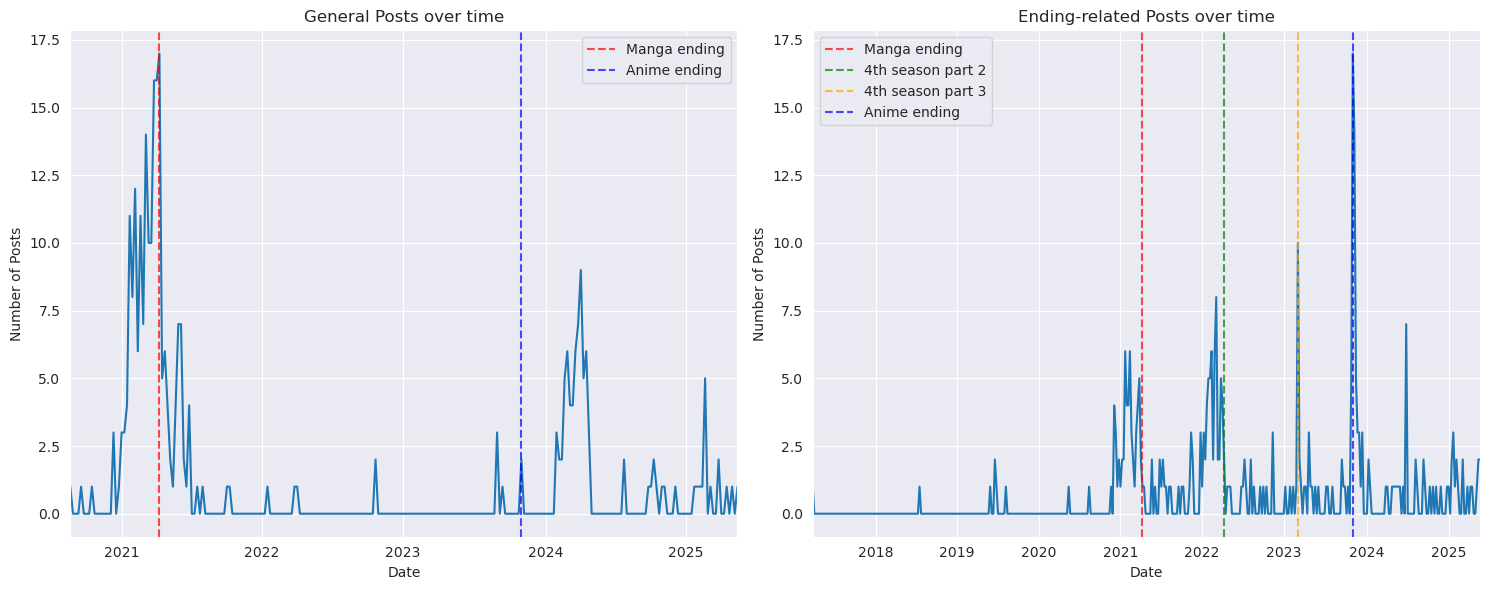

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# W stands for Week
df_general.set_index('created_utc').resample('W').size().plot(ax=axes[0], title="General Posts over time")
axes[0].axvline(pd.to_datetime('2021-04-09'), color='red', linestyle='--', alpha=0.7, label='Manga ending')
axes[0].axvline(pd.to_datetime('2023-11-05'), color='blue', linestyle='--', alpha=0.7, label='Anime ending')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Posts')
axes[0].legend()

df_ending.set_index('created_utc').resample('W').size().plot(ax=axes[1], title="Ending-related Posts over time")
axes[1].axvline(pd.to_datetime('2021-04-09'), color='red', linestyle='--', alpha=0.7, label='Manga ending')
axes[1].axvline(pd.to_datetime('2022-04-04'), color='green', linestyle='--', alpha=0.7, label='4th season part 2')
axes[1].axvline(pd.to_datetime('2023-03-04'), color='orange', linestyle='--', alpha=0.7, label='4th season part 3')
axes[1].axvline(pd.to_datetime('2023-11-05'), color='blue', linestyle='--', alpha=0.7, label='Anime ending')


axes[1].set_xlabel('Date')
axes[1].set_ylabel('Number of Posts')
axes[1].legend()

plt.tight_layout()
plt.show()

The number of posts peaked on the manga or anime ending, or during the releases of new seasons.

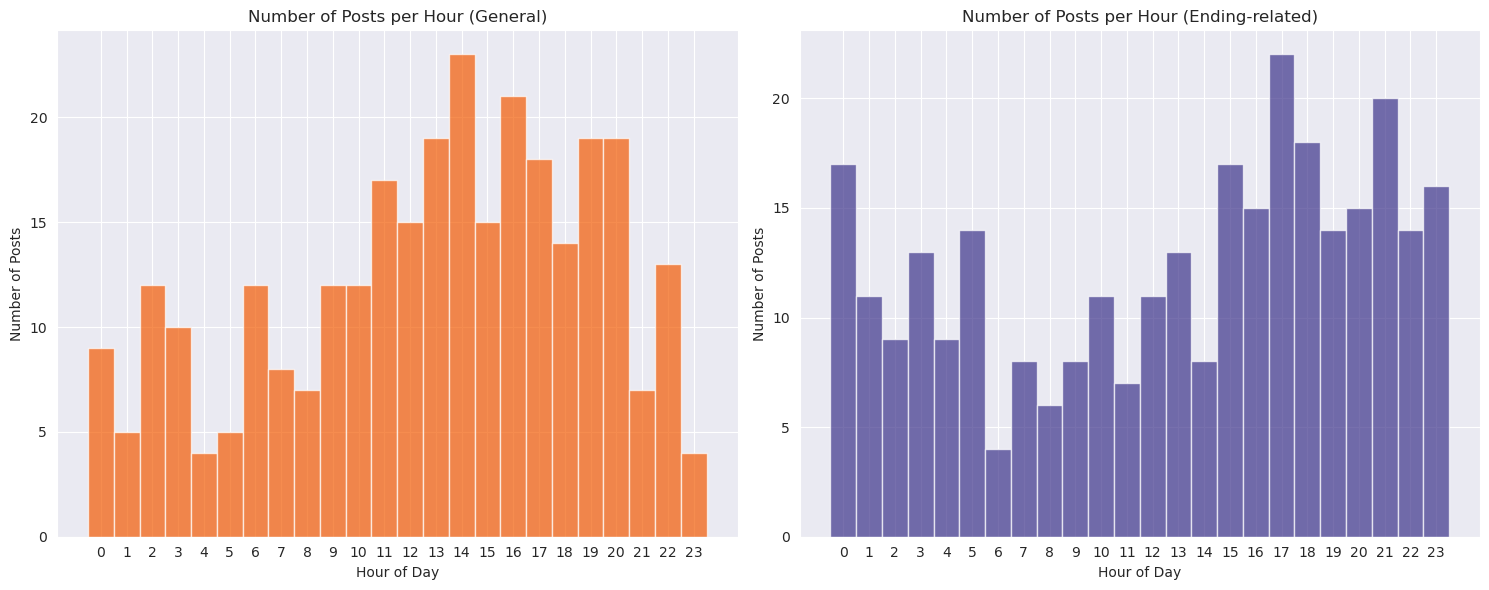

In [14]:
# Extract hour from datetime
df_general['hour'] = df_general['created_utc'].dt.hour
df_ending['hour'] = df_ending['created_utc'].dt.hour

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot histograms with bars centered on integer hours
df_general['hour'].hist(bins=np.arange(25)-0.5, ax=axes[0], color='#f35b04', alpha=0.7)
axes[0].set_title("Number of Posts per Hour (General)")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Number of Posts")
axes[0].set_xticks(range(0, 24))

df_ending['hour'].hist(bins=np.arange(25)-0.5, ax=axes[1], color='#3d348b', alpha=0.7)
axes[1].set_title("Number of Posts per Hour (Ending-related)")
axes[1].set_xlabel("Hour of Day")
axes[1].set_ylabel("Number of Posts")
axes[1].set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

### Selftext of the submissions

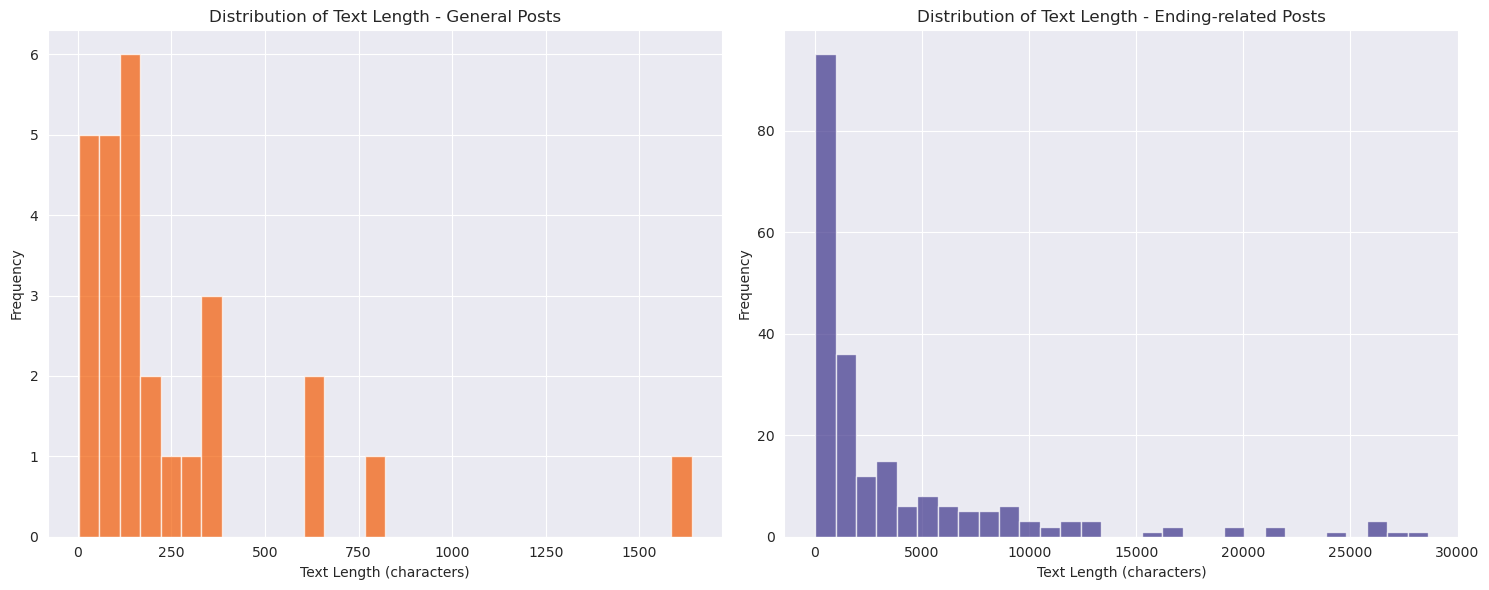

General posts - Mean text length: 524.4 characters
Ending posts - Mean text length: 4130.9 characters


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Calculate text length for general posts
df_general['text_length'] = df_general['selftext'].dropna().str.len()
df_ending['text_length'] = df_ending['selftext'].dropna().str.len()

# Filter out extreme outliers for better visualization (99th percentile)
general_length_99th = df_general['text_length'].quantile(0.99)
ending_length_99th = df_ending['text_length'].quantile(0.99)

df_general[df_general['text_length'] <= general_length_99th]['text_length'].hist(bins=30, ax=axes[0], alpha=0.7, color='#f35b04')
axes[0].set_title("Distribution of Text Length - General Posts")
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Frequency')

df_ending[df_ending['text_length'] <= ending_length_99th]['text_length'].hist(bins=30, ax=axes[1], alpha=0.7, color='#3d348b')
axes[1].set_title("Distribution of Text Length - Ending-related Posts")
axes[1].set_xlabel('Text Length (characters)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"General posts - Mean text length: {df_general['text_length'].mean():.1f} characters")
print(f"Ending posts - Mean text length: {df_ending['text_length'].mean():.1f} characters")

People talking about the ending of anime write much longer texts.

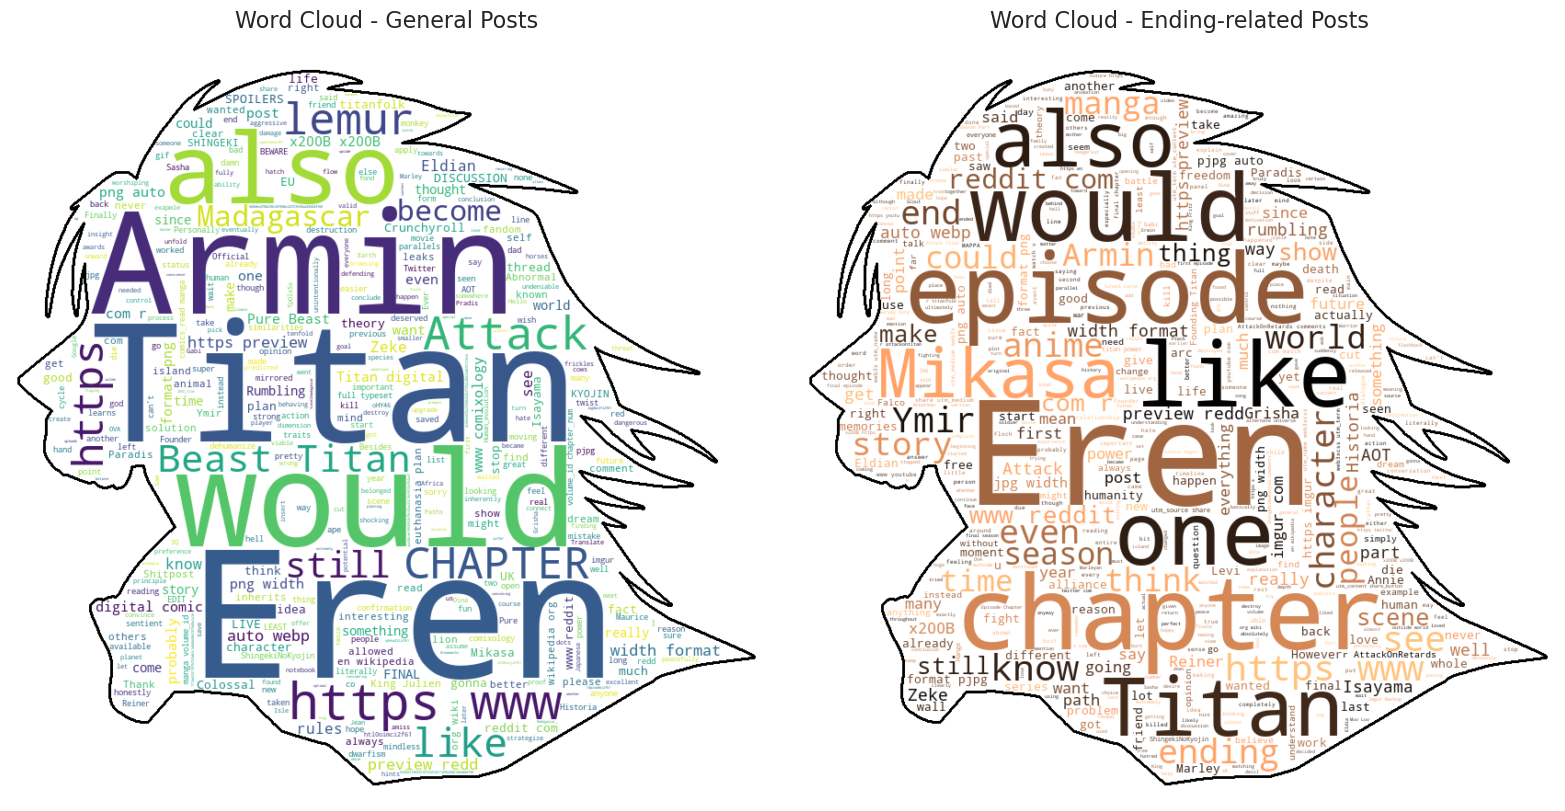

In [10]:
# mask
img = Image.open('../images/mask_erenTitanForm.jpeg')
eren_mask = np.array(img).mean(axis=2).astype(np.uint8)
threshold = 128  # You can adjust this value
eren_mask = np.where(eren_mask > threshold, 255, 0).astype(np.uint8)


nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words('english'))

# Combine all selftext
all_selftext_general = ' '.join(df_general['selftext'].dropna().astype(str))
all_selftext_ending = ' '.join(df_ending['selftext'].dropna().astype(str))

# Create word clouds for both datasets
wordcloud_general = WordCloud(width=800, height=400, 
                             stopwords=STOPWORDS, max_words=500,
                             background_color='white', colormap='viridis',
                             mask=eren_mask, contour_width=2, contour_color='black' # MASK
                    ).generate(all_selftext_general)

wordcloud_ending = WordCloud(width=800, height=400, 
                             stopwords=STOPWORDS, max_words=500,
                             background_color='white', colormap='copper',
                             mask=eren_mask, contour_width=2, contour_color='black' # MASK
                    ).generate(all_selftext_ending)


fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(wordcloud_general, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud - General Posts', fontsize=16)
axes[1].imshow(wordcloud_ending, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud - Ending-related Posts', fontsize=16)
plt.tight_layout()
plt.show()

We update our list of stopwords with aot related words (characters names for example), domain specific words (ending, chapter, anime...) and other words that are just very common and are not useful in the worldcloud (also, like, would, even,..)

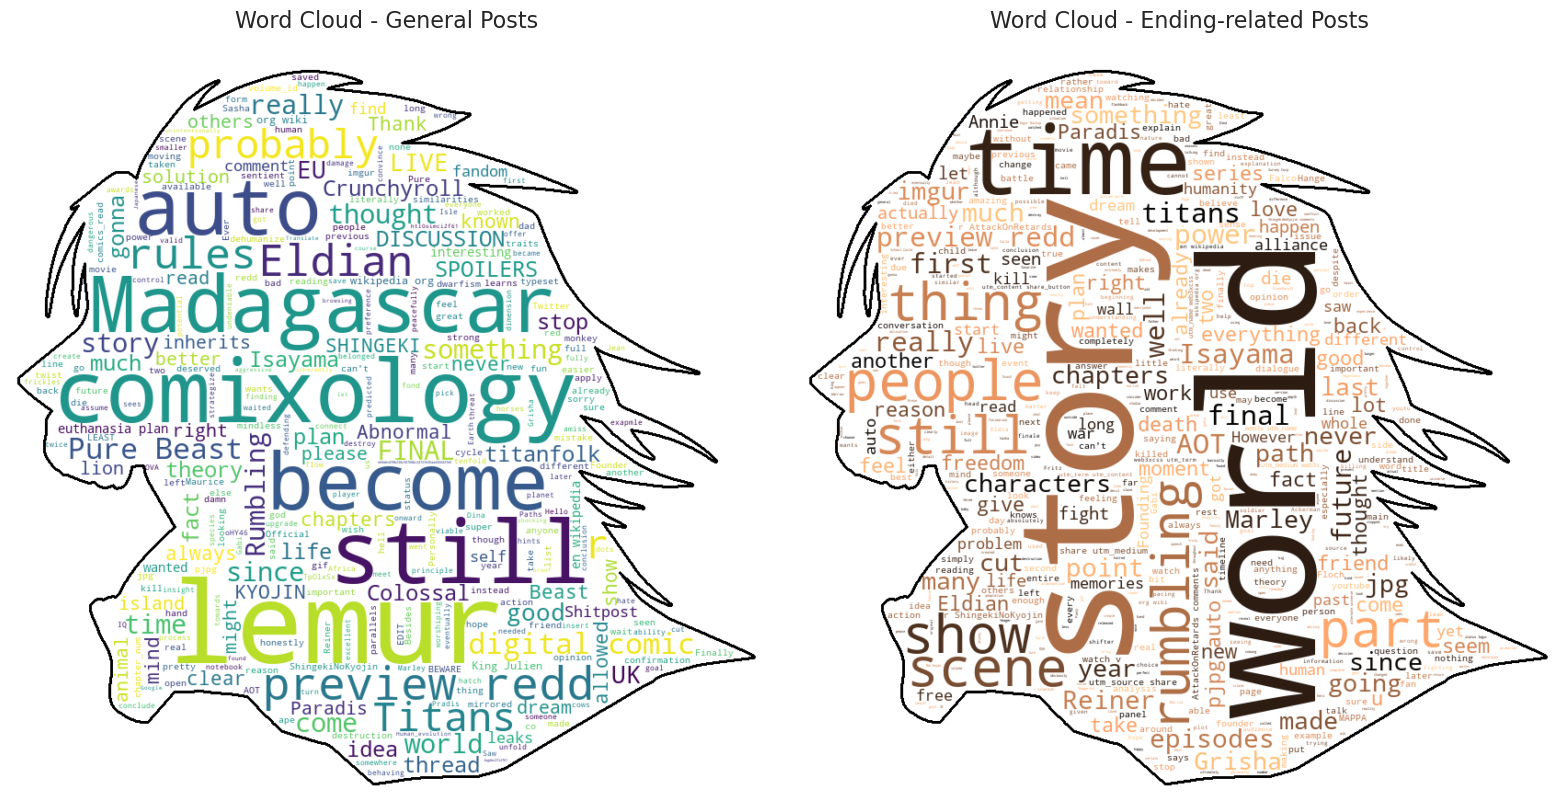

In [11]:
# UPDATE STOPWORDS
STOPWORDS.update([
    'Eren', 'Armin', 'Mikasa', 'Levi', 'Zeke', 'Ymir', 'Historia', 'Attack', 'Titan',
    'ending', 'chapter', 'anime', 'manga', 'episode', 'character', 'season',
    'www', 'https', 'x200B', 'com', 'reddit', 'webp', 'png',
    # a bunch of common words that are not useful for the word cloud
    'also', 'like', 'would', 'even', 'think', 'get', 'want', 'one', 'see','know', 'say',
    'format', 'width', 'post', 'arc', 'way', 'make', 'could', 'end'
])

# Create word clouds for both datasets
wordcloud_general = WordCloud(width=800, height=400, 
                             stopwords=STOPWORDS, max_words=500,
                             background_color='white', colormap='viridis',
                             mask=eren_mask, contour_width=2, contour_color='black' # MASK
                    ).generate(all_selftext_general)

wordcloud_ending = WordCloud(width=800, height=400, 
                             stopwords=STOPWORDS, max_words=500,
                             background_color='white', colormap='copper',
                             mask=eren_mask, contour_width=2, contour_color='black' # MASK
                    ).generate(all_selftext_ending)


fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(wordcloud_general, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud - General Posts', fontsize=16)
axes[1].imshow(wordcloud_ending, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Word Cloud - Ending-related Posts', fontsize=16)
plt.tight_layout()
plt.show()

In [12]:
print(f"Number of times 'lemur' appear in general posts: {all_selftext_general.lower().count('lemur')}")
print(f"Number of times 'madagascar' appear in general posts: {all_selftext_general.lower().count('madagascar')}")

print(f"Number of times 'lemur' appear in ending posts: {all_selftext_ending.lower().count('lemur')}")
print(f"Number of times 'madagascar' appear in ending posts: {all_selftext_ending.lower().count('madagascar')}")

Number of times 'lemur' appear in general posts: 11
Number of times 'madagascar' appear in general posts: 10
Number of times 'lemur' appear in ending posts: 0
Number of times 'madagascar' appear in ending posts: 2


"lemur" and "Madagascar" refer to a meme in the community where the protagonist of AoT (Eren) is compared to the lemur (King Julien) from the cartoon Madagascar, due to some dialogue.

<div style="display: flex; gap: 10px;">
  <img src="../images/meme_1.webp" alt="Image 1" width="400"/>
  <img src="../images/meme_2.webp" alt="Image 1" width="400"/>
</div>

_

<div style="display: flex; gap: 10px; align-items: center;">
  <img src="../images/meme_3.webp" alt="Image 1" width="400"/>
  <img src="../images/meme_4.gif" alt="GIF" width="400"/>
</div>

[reference](https://www.reddit.com/r/AttackOnRetards/comments/rneo2n/madagascar_meme_i_like_to_move_it_move_it/)


### Top posts by score

In [13]:
N = 5
for row in df_general.nlargest(N, 'score')[['title', 'score']].itertuples():
    print(f"SCORE: {row.score}\nTITLE: {row.title}\n" + "-"*80)

SCORE: 29142
TITLE: I built Shiganshina in Minecraft 1:1
--------------------------------------------------------------------------------
SCORE: 26708
TITLE: How do I even react to this??
--------------------------------------------------------------------------------
SCORE: 26055
TITLE: Attack on Titanfolk Opening
--------------------------------------------------------------------------------
SCORE: 24543
TITLE: Dad: "Stop watching those stupid cartoons!" Two episodes later:
--------------------------------------------------------------------------------
SCORE: 23331
TITLE: well?
--------------------------------------------------------------------------------


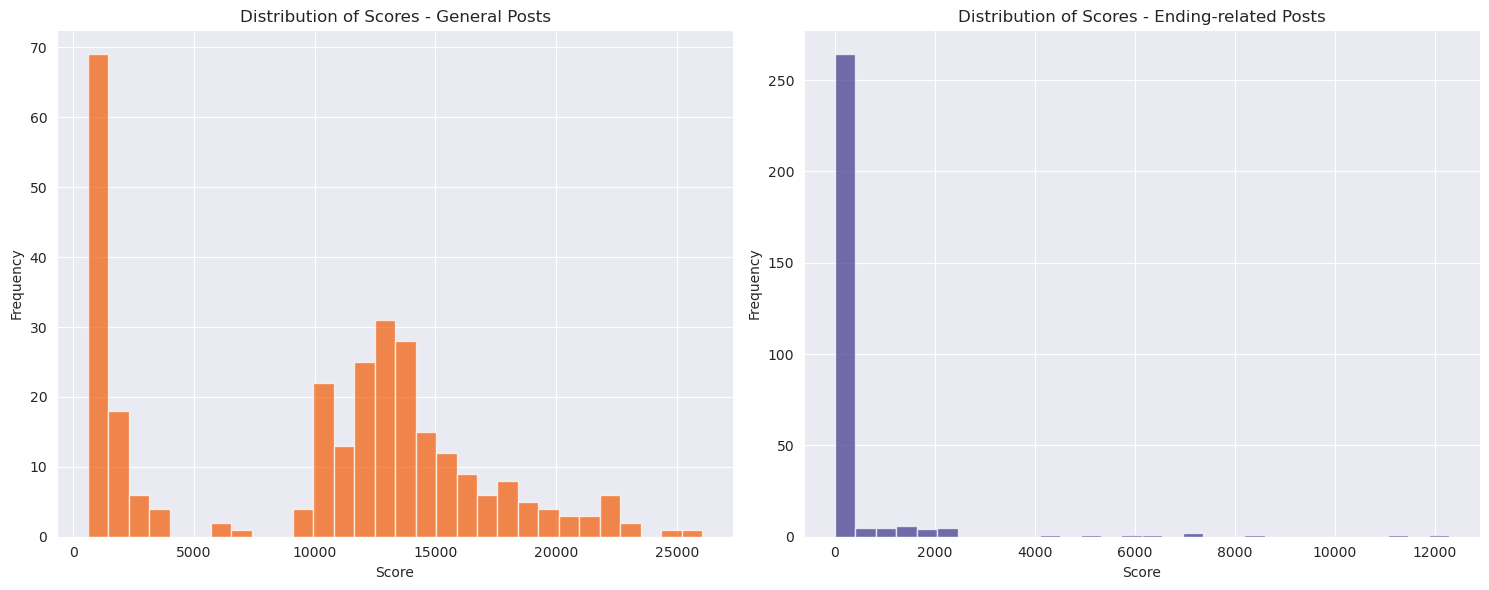

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# filter out 99.5 percentile for better visualization
# just a cutoff to avoid extreme outliers
general_95th = df_general['score'].quantile(0.995)
ending_95th = df_ending['score'].quantile(0.995)

df_general[df_general['score'] <= general_95th]['score'].hist(bins=30, ax=axes[0], alpha=0.7, color='#f35b04')
axes[0].set_title("Distribution of Scores - General Posts")
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frequency')

df_ending[df_ending['score'] <= ending_95th]['score'].hist(bins=30, ax=axes[1], alpha=0.7, color="#3d348b")
axes[1].set_title("Distribution of Scores - Ending-related Posts")
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

And here the upvotes ratio

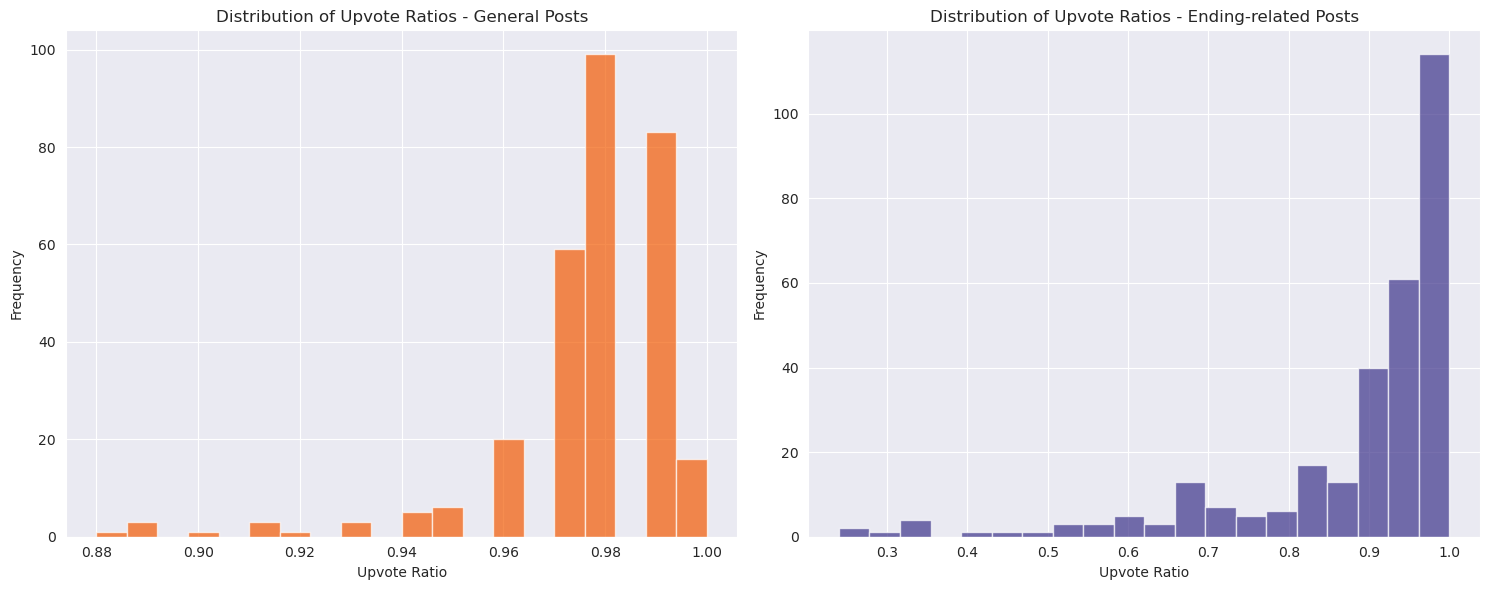

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

df_general['upvote_ratio'].hist(bins=20, alpha=0.7, ax=axes[0], color='#f35b04')
axes[0].set_title("Distribution of Upvote Ratios - General Posts")
axes[0].set_xlabel('Upvote Ratio')
axes[0].set_ylabel('Frequency')

df_ending['upvote_ratio'].hist(bins=20, alpha=0.7, ax=axes[1], color="#3d348b")
axes[1].set_title("Distribution of Upvote Ratios - Ending-related Posts")
axes[1].set_xlabel('Upvote Ratio')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Number of comments

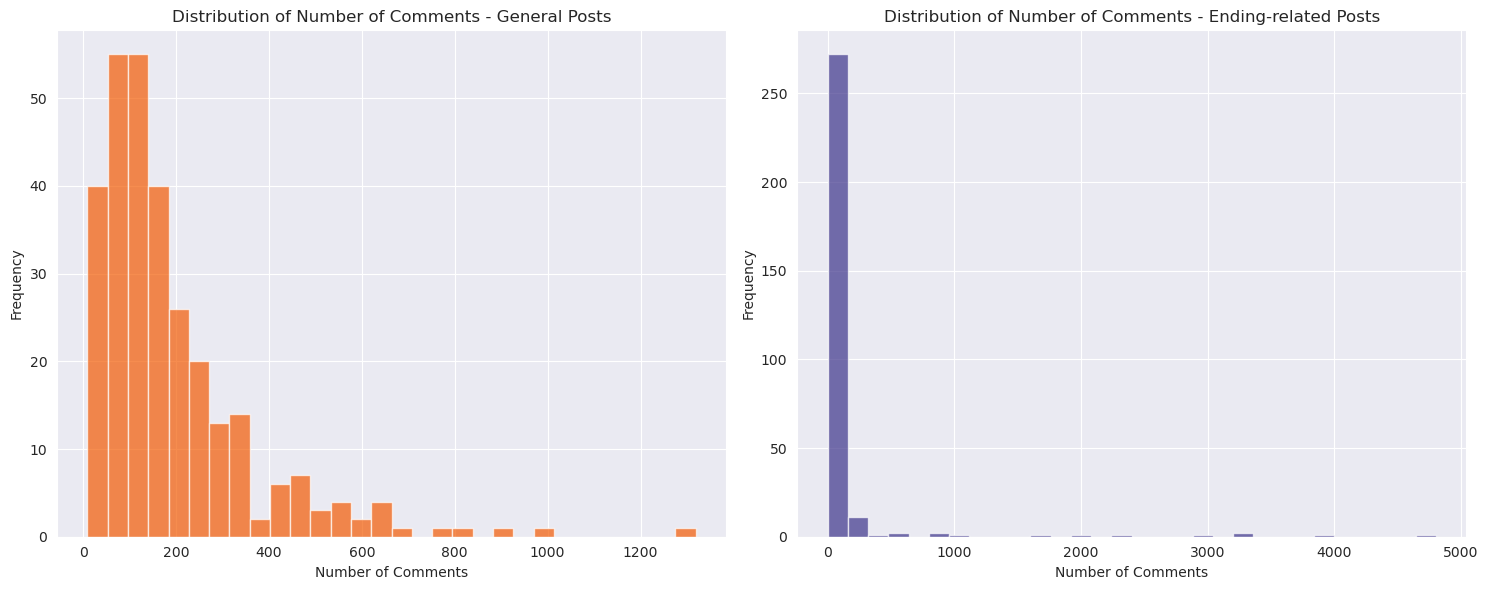

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Filter out extreme outliers for better visualization (99th percentile)
general_comments_95th = df_general['num_comments'].quantile(0.99)
ending_comments_95th = df_ending['num_comments'].quantile(0.99)

df_general[df_general['num_comments'] <= general_comments_95th]['num_comments'].hist(bins=30, ax=axes[0], alpha=0.7, color='#f35b04')
axes[0].set_title("Distribution of Number of Comments - General Posts")
axes[0].set_xlabel('Number of Comments')
axes[0].set_ylabel('Frequency')

df_ending[df_ending['num_comments'] <= ending_comments_95th]['num_comments'].hist(bins=30, ax=axes[1], alpha=0.7, color='#3d348b')
axes[1].set_title("Distribution of Number of Comments - Ending-related Posts")
axes[1].set_xlabel('Number of Comments')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Flair text

Post Flair is and additional bit of info that is a tag you select when creating a post. It usually allows the subreddit to be sorted by that or it helps to make a quick identificaion about the post

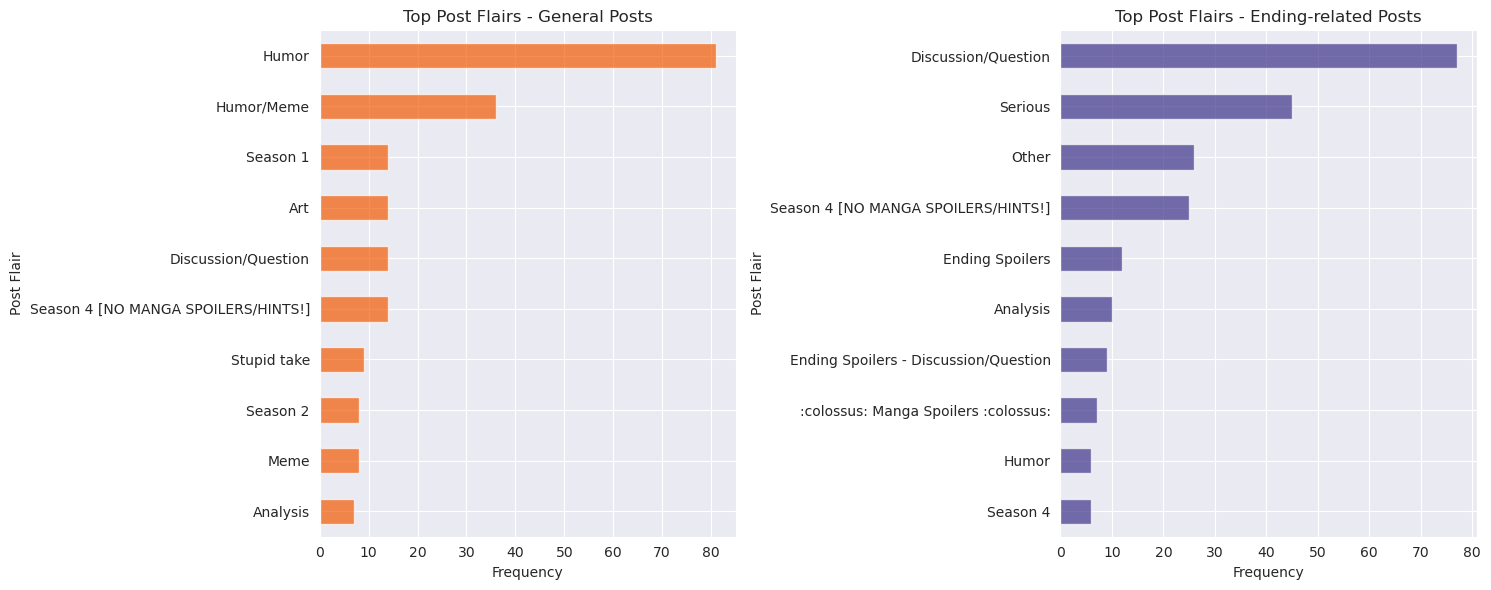

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# have seen that in the data appears "Discussion" and "Discussion ", so we strip the whitespace
df_general['link_flair_text'] = df_general['link_flair_text'].str.strip()
df_ending['link_flair_text'] = df_ending['link_flair_text'].str.strip()

df_general['link_flair_text'].value_counts().head(10).sort_values().plot(kind='barh', ax=axes[0], alpha=0.7, color='#f35b04')
axes[0].set_title("Top Post Flairs - General Posts")
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Post Flair')

df_ending['link_flair_text'].value_counts().head(10).sort_values().plot(kind='barh', ax=axes[1], alpha=0.7, color='#3d348b')
axes[1].set_title("Top Post Flairs - Ending-related Posts")
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Post Flair')

plt.tight_layout()
plt.show()


The whole unfiltered subreddit is more about Humor and Memes, while the second is more about Discussions. 

### Spoiler distribution

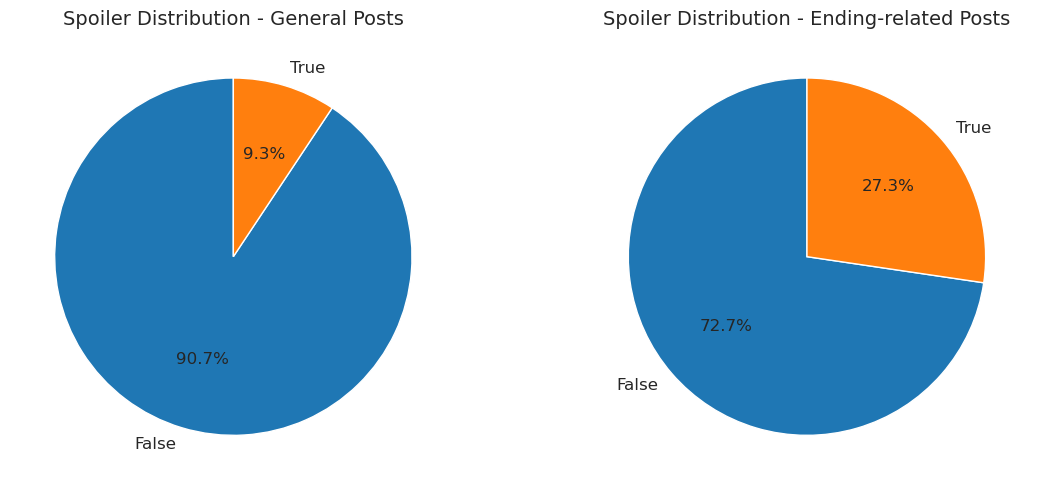

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

spoiler_counts_general = df_general['spoiler'].value_counts()
axes[0].pie(spoiler_counts_general.values, labels=spoiler_counts_general.index, autopct='%1.1f%%', 
           startangle=90, textprops={'fontsize': 12})
axes[0].set_title('Spoiler Distribution - General Posts', fontsize=14)

spoiler_counts_ending = df_ending['spoiler'].value_counts()
axes[1].pie(spoiler_counts_ending.values, labels=spoiler_counts_ending.index, autopct='%1.1f%%', 
           startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Spoiler Distribution - Ending-related Posts', fontsize=14)

plt.tight_layout()
plt.show()